In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [54]:
img_config = {
    'img_size': {
        'x': 512,
        'y': 512,
    },
    'path': {
        'golden_gate': 'E://Image Datasets//Style Transfer Images//Content Images//GoldenGate.jpg',
    }
}

load_img = lambda x: np.array(Image.open(x).resize([img_config['img_size']['x'], img_config['img_size']['y']]))

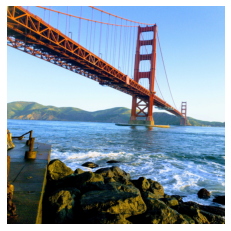

In [27]:
img = load_img(img_config['path']['golden_gate'])
plt.imshow(img)
plt.axis('off')
plt.show()

In [55]:
def get_model(base_model, layers):
    assert isinstance(layers, list)
    if base_model.trainable:
        base_model.trainable = False
        
    outs = [base_model.get_layer(layer).output for layer in layers]
    return tf.keras.models.Model(base_model.inputs, outs)

preprocess_input = lambda x: tf.keras.applications.inception_v3.preprocess_input(x)
deprocess_input = lambda x: (x + 1) * 127.5

In [20]:
layers = ['mixed3', 'mixed5']
model = get_model(tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet'), layers)

In [121]:
def get_loss(layers):
    loss = 0
    for layer in layers:
        loss += tf.math.reduce_mean(layers)
    return loss

In [128]:
epochs = 100
lr = 0.01
img = tf.convert_to_tensor(preprocess_input(load_img(img_config['path']['golden_gate'])))
img = tf.expand_dims(img, 0)

for e in range(epochs):
    
    with tf.GradientTape() as tape:
        tape.watch(img)
        outs = model(img)
        loss = get_loss(outs)
        
    grads = tape.gradient(loss, img)
    grads /= tf.math.reduce_std(grads) + 1e-8
    
    img += lr * grads
    img = tf.clip_by_value(img, -1, 1)

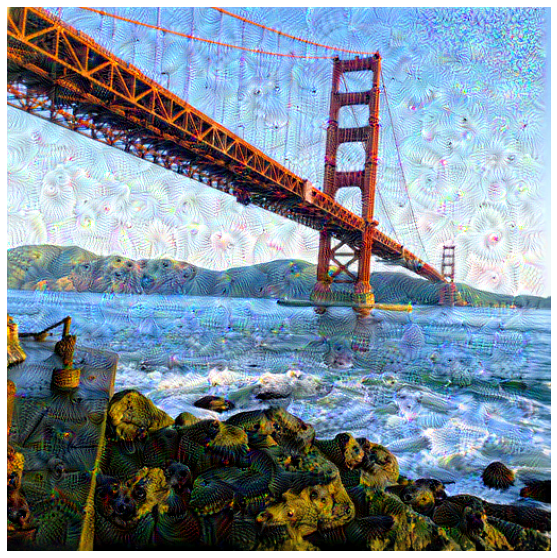

In [129]:
plt.figure(figsize = (10, 10))
plt.imshow(deprocess_input(img[0]).numpy().astype('uint8'))
plt.axis('off')
plt.show()

In [135]:
scales = [-2, -1, 0, 1, 2] #range(-2, 3)
octave = 1.3
epochs = 100
lr = 0.01

scaled_images = []
out = tf.expand_dims(load_img(img_config['path']['golden_gate']), 0)

for scl in scales:    
    img_size = int((octave ** scl) * 512)
    out = tf.image.resize(out, [img_size, img_size])
    out = preprocess_input(out)
    for e in range(epochs):
        with tf.GradientTape() as tape:
            tape.watch(out)
            out_layers = model(out)
            loss = get_loss(out_layers)
            
        grads = tape.gradient(loss, out)
        grads /= tf.math.reduce_std(grads) + 1e-8
        
        out += lr * grads
        out = tf.clip_by_value(out, -1, 1)
        
    out = deprocess_input(out)
    scaled_images.append(out)

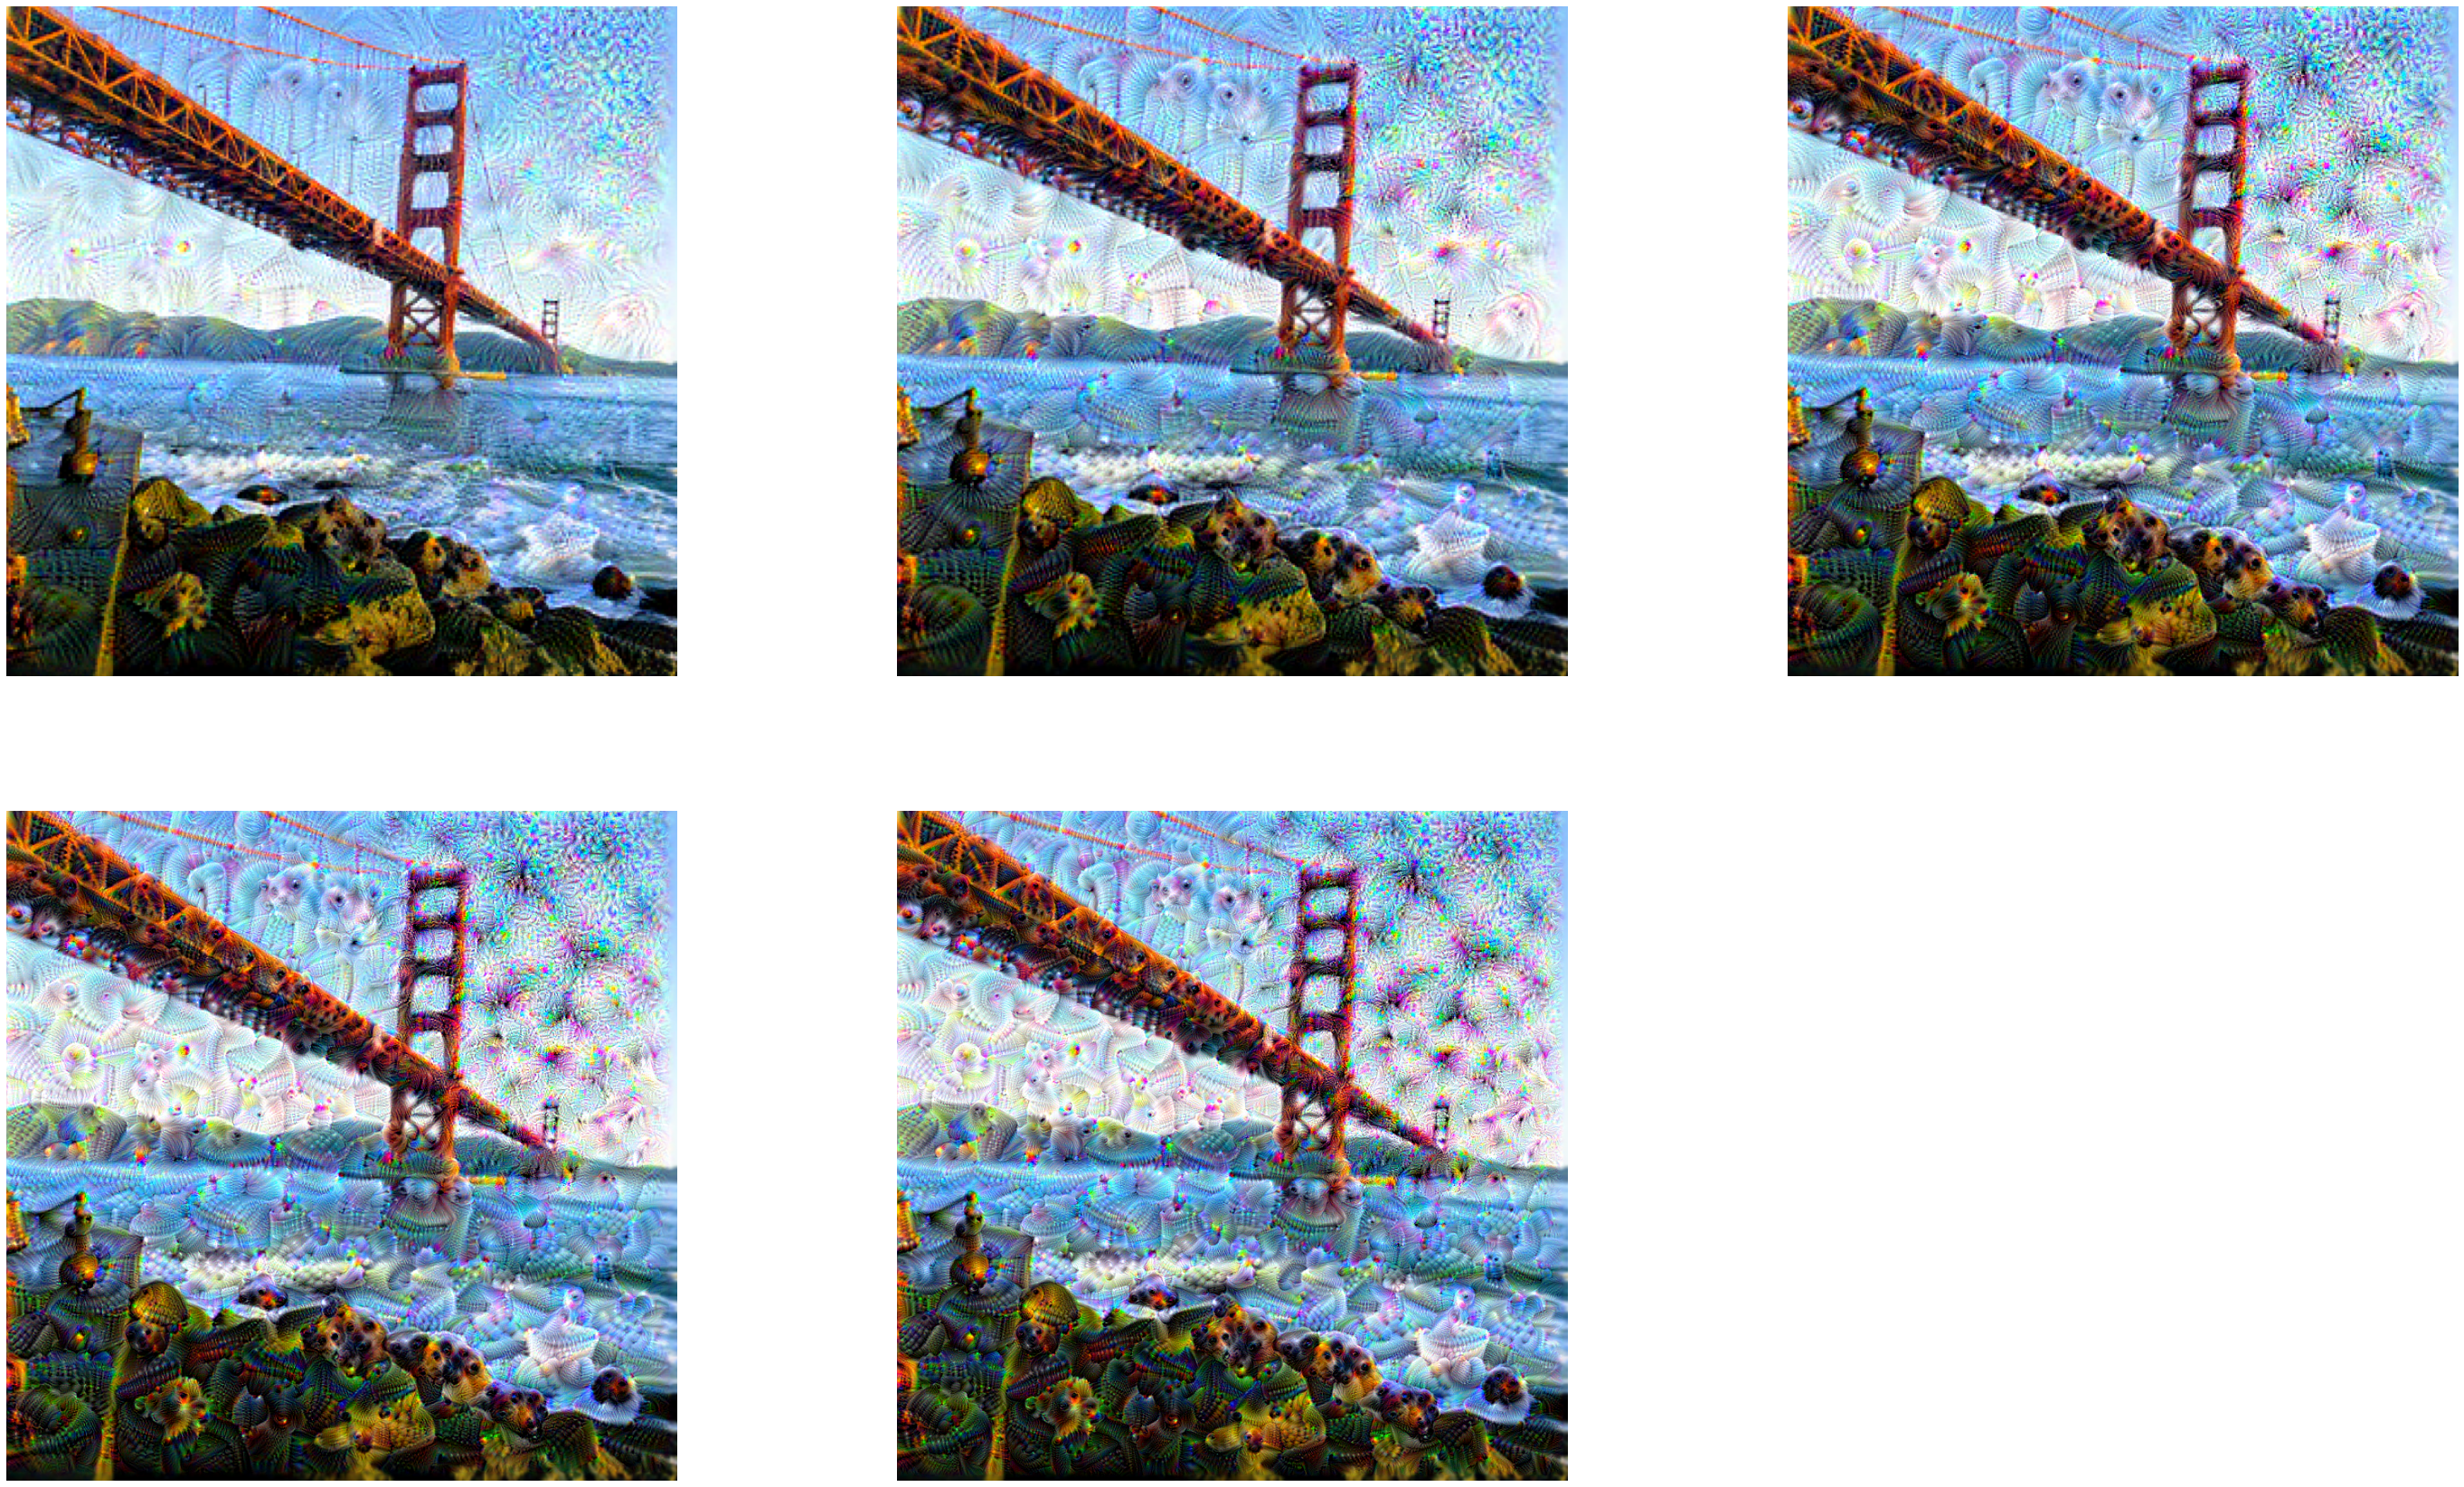

In [144]:
plt.figure(figsize = (50, 35))

for i, im in enumerate(scaled_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(im[0].numpy().astype('uint8'))
    plt.axis('off')
    
plt.show()